In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
from Clustering_Functions import *
import numpy as np
from sklearn.metrics import silhouette_score

In [2]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
def sil_score(election, C, num_cands):
    labels = []
    XH = []  # first build list of ballot proxies with repititions
    for ballot, weight in election.items():
        for _ in range(weight):
            XH.append(HH_proxy(ballot, num_cands=num_cands))
            label = 0 if ballot in C[0].keys() else 1
            labels.append(label)
    return silhouette_score(XH, labels, metric="manhattan")

In [5]:
# The Pentland Hills election that's studied in the paper
filename = 'scot-elex/7_cands/edinburgh_2017_ward2.csv'
num_cands, election, cand_names, ward = csv_parse(filename)
parties = party_abrevs(cand_names)

In [9]:
C_s = Slate_cluster(election, dist='strong', verbose = True)
print("\n")
C_w = Slate_cluster(election, dist='weak', verbose = True)

Slates = ((1, 6), (2, 3, 4, 5, 7)).
Portion of ballots that tied = 0.005567830313742819
Portion of ballots that are strongly consistent = 0.4269553689792311
Average distance to ordered = 0.1552938577110035


Slates = ((3,), (1, 2, 4, 5, 6, 7)).
Portion of ballots that tied = 0.017587273530711444
Portion of ballots that are weakly consistent = 0.7995581087052585
Average distance to ordered = 0.04826925909559583


In [10]:
C_su = Slate_cluster(election, dist='strong', verbose = True, normalized=False)
print("\n")
C_wu = Slate_cluster(election, dist='weak', verbose = True, normalized=False)

Slates = ((1,), (2, 3, 4, 5, 6, 7)).
Portion of ballots that tied = 0.019531595227574017
Portion of ballots that are strongly consistent = 0.30861688024745915
Average distance to ordered = 0.18031374281926613


Slates = ((3,), (1, 2, 4, 5, 6, 7)).
Portion of ballots that tied = 0.017587273530711444
Portion of ballots that are weakly consistent = 0.7995581087052585
Average distance to ordered = 0.04826925909559583


In [11]:
C = kmeans(election)

In [14]:
print(Clustering_closeness(election, C,C_s))
print(Clustering_closeness(election, C,C_w))
print(Clustering_closeness(election, C,C_su))
print(Clustering_closeness(election, C,C_wu))

0.02620415377817057
0.17247017233760495
0.05112682280159081
0.17247017233760495


Build a dataframe with one row for each 7-candidate Scottish election.  Three clustering methods are used on each election: kmeans, strong slate-clustering, weak slate-clustering.  The non-obvious columns are:

- kmeans_strong: closeness of the kmeans and strong-slate clusterings
- kmeans_weak: closeness of the kmeans and weak-slate clusterings
- s_slates, w_slates: slates from s=strong and w=weak slate-clustering
- s_slates_p, w_slates_p: slates by party
- s_portion, w_portion: portion of consistent ballots (s=strong, w=weak)
- s_dist, w_dist: average distance of a ballot to the closest condition: A>B or B>A
- s_sil, w_sil, kmeans_sil: silhouette score

In [ ]:
# make dataframe of 7-candidate elections clustered by strong and weak slate-cluatering
filename_list = glob.glob("scot-elex/7_cands/*.csv")
df = pd.DataFrame(columns=['filename', 'num_cands', 'parties',
                           'kmeans_sil', 'kmeans_strong', 'kmeans_weak',
                           's_slates', 's_slates_p', 's_portion', 's_dist', 's_sil', 
                           'w_slates', 'w_slates_p', 'w_portion', 'w_dist', 'w_sil'])
for filename in filename_list:
    num_cands, election, cand_names, location = csv_parse(filename)
    print(filename)
    parties = {i+1: party for i,party in enumerate(party_abrevs(cand_names))}

    # kmeans 
    C = kmeans(election)
    kmeans_sil = sil_score(election, C, num_cands)

    # strong slate clustering
    s_slates, s_dist, s_portion, Cs = Slate_cluster(election, dist='strong', return_data=True)
    s_sil = sil_score(election, Cs, num_cands)
    kmeans_strong = Clustering_closeness(election, C, Cs)
    s_slates_p = {i:tuple([parties[cand] for cand in s_slate]) for i,s_slate in s_slates.items()}
    print(f'     strong {s_slates_p[0],s_slates_p[1]}, score: {kmeans_strong}')

    # weak slate clustering
    w_slates, w_dist, w_portion, Cw = Slate_cluster(election, dist='weak', return_data=True)
    w_sil = sil_score(election, Cw, num_cands) 
    kmeans_weak = Clustering_closeness(election, C, Cw)
    w_slates_p = {i:tuple([parties[cand] for cand in w_slate]) for i,w_slate in w_slates.items()}
    print(f'     weak {w_slates_p[0],w_slates_p[1]}, score: {kmeans_weak}')

    # add a row to the dataframe
    row_num = df.shape[0]
    df.loc[row_num] = [filename, num_cands, parties, 
                       kmeans_sil, kmeans_strong, kmeans_weak,
                       s_slates, s_slates_p, s_portion, s_dist, s_sil,
                       w_slates, w_slates_p, w_portion, w_dist, w_sil]

In [16]:
df.to_csv('7_cand_slates.csv')

<Axes: xlabel='kmeans_strong', ylabel='Density'>

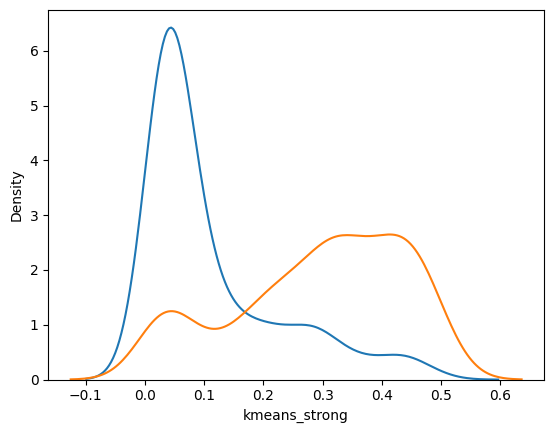

In [19]:
sns.kdeplot(df['kmeans_strong'], label='strong')
sns.kdeplot(df['kmeans_weak'], label='weak')

In [37]:
s_len_list = []
w_len_list = []
for index in df.index:
    s_len = len(df.loc[index, 's_slates'][0])
    w_len = len(df.loc[index, 'w_slates'][0])
    s_len_list.append(s_len)
    w_len_list.append(w_len)
df['s_len'] = s_len_list
df['w_len'] = w_len_list

<Axes: xlabel='s_len', ylabel='Count'>

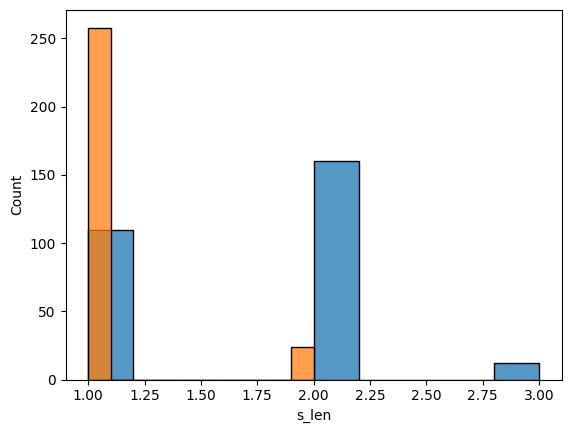

In [41]:
sns.histplot(df['s_len'])
sns.histplot(df['w_len'])

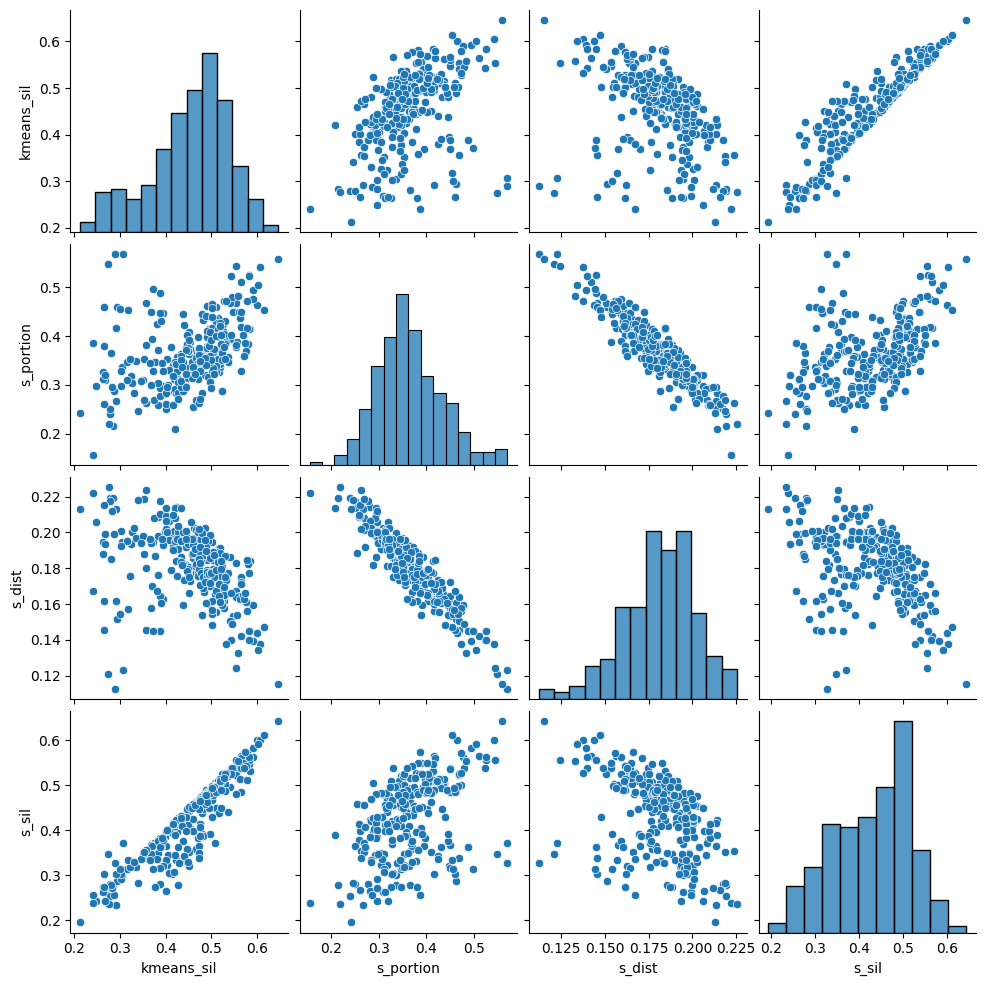

In [20]:
sns.pairplot(df[['kmeans_sil','s_portion', 's_dist', 's_sil']])

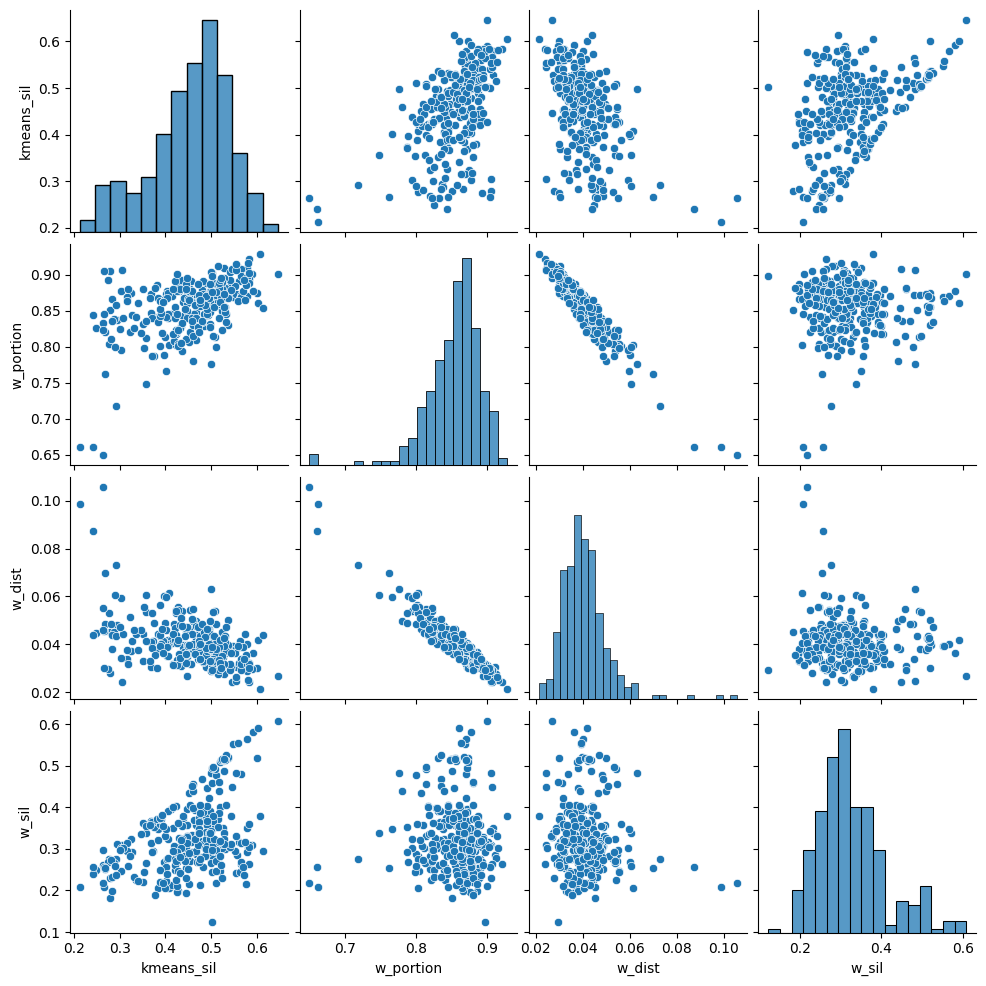

In [22]:
sns.pairplot(df[['kmeans_sil','w_portion', 'w_dist', 'w_sil']])

<Axes: xlabel='s_dist', ylabel='kmeans_sil'>

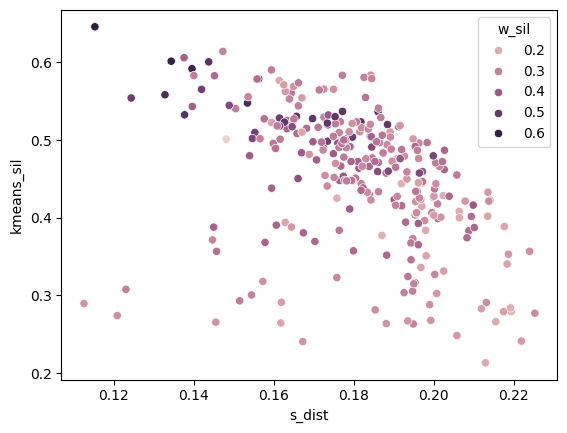

In [23]:
sns.scatterplot(data=df, x='s_dist', y='kmeans_sil', hue='w_sil')

In [24]:
print(df[df['kmeans_sil']>0.62]['filename']) # most polarized election 
print(df[df['kmeans_sil']<.22]['filename']) # least polarized election

239    scot-elex/7_cands\south_ayrshire_2017_ward5.csv
Name: filename, dtype: object
236    scot-elex/7_cands\shetland_2022_ward6.csv
Name: filename, dtype: object


In [25]:
# study the MOST polarized election
index = 239
filename = df['filename'][index]
num_cands, election, cand_names, location = csv_parse(filename)
parties = party_abrevs(cand_names)
# kmeans 
C = kmeans(election)
# strong slate clustering
s_slates, s_dist, s_portion, Cs = Slate_cluster(election, dist='strong', return_data=True)
kmeans_strong = Clustering_closeness(election, C, Cs)
s_slates_p = {i:tuple([parties[cand-1] for cand in s_slate]) for i,s_slate in s_slates.items()}
print(f'     strong {s_slates_p[0],s_slates_p[1]}, score: {kmeans_strong}')
# weak slate clustering
w_slates, w_dist, w_portion, Cw = Slate_cluster(election, dist='weak', return_data=True)
kmeans_weak = Clustering_closeness(election, C, Cw)
w_slates_p = {i:tuple([parties[cand-1] for cand in w_slate]) for i,w_slate in w_slates.items()}
print(f'     weak {w_slates_p[0],w_slates_p[1]}, score: {kmeans_weak}')

# Ballot MDS plots
# projections_5, error = Ballot_MDS_plot(election, party_names=parties, return_data=True, threshold=1, filename='ward5.jpg', dpi=300) #colored by party of first place vote
# Ballot_MDS_plot(election, Cs, projections=projections) #colored by strong slate clustering assignment
# Ballot_MDS_plot(election, [Cw[1],Cw[0]],projections=projections) # colored by weak slate clustering assignment
# Ballot_MDS_plot(election, C,projections=projections) # colored by kmeans clustering assignment

# Candidate MDS plots
#Candidate_MDS_plot(election, party_names = parties, party_colors = 'Auto')
#Candidate_MDS_plot(election, party_names = parties, party_colors = 'Auto', dimension=1, filename='ward5_1D.jpg', dpi=300)

     strong (('Con', 'Con', 'Con'), ('Ind', 'SNP', 'SNP', 'Lab')), score: 0.012666748256027415
     weak (('SNP', 'SNP'), ('Ind', 'Con', 'Con', 'Lab', 'Con')), score: 0.09221637498470199


In [26]:
s_slates, w_slates

({0: (4, 5, 7), 1: (1, 2, 3, 6)}, {0: (2, 3), 1: (1, 4, 5, 6, 7)})

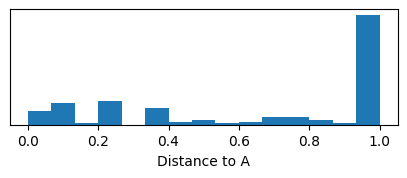

In [29]:
Slate_Histplot(election, s_slates[0], dist='strong', bins=15, dpi=100)

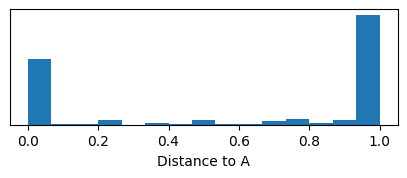

In [30]:
Slate_Histplot(election, s_slates[0], dist='weak', bins=15, dpi=100)

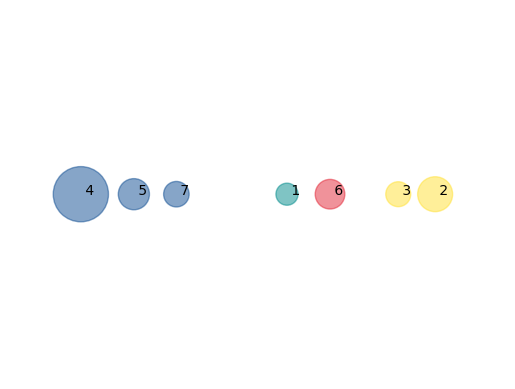

In [31]:
Candidate_MDS_plot(election, party_names = parties, party_colors = 'Auto', dimension=1, dpi=100)

In [32]:
# study the LEAST polarized election
index = 236
filename = df['filename'][index]
num_cands, election, cand_names, location = csv_parse(filename)
parties = party_abrevs(cand_names)
# kmeans 
C = kmeans(election)
# strong slate clustering
s_slates, s_dist, s_portion, Cs = Slate_cluster(election, dist='strong', return_data=True)
kmeans_strong = Clustering_closeness(election, C, Cs)
s_slates_p = {i:tuple([parties[cand-1] for cand in s_slate]) for i,s_slate in s_slates.items()}
print(f'     strong {s_slates_p[0],s_slates_p[1]}, score: {kmeans_strong}')
# weak slate clustering
w_slates, w_dist, w_portion, Cw = Slate_cluster(election, dist='weak', return_data=True)
kmeans_weak = Clustering_closeness(election, C, Cw)
w_slates_p = {i:tuple([parties[cand-1] for cand in w_slate]) for i,w_slate in w_slates.items()}
print(f'     weak {w_slates_p[0],w_slates_p[1]}, score: {kmeans_weak}')

# Ballot MDS plots
# projections_6, error = Ballot_MDS_plot(election, party_names=parties, return_data=True, threshold=1, filename='ward6.jpg', dpi = 300) #colored by party of first place vote
#Ballot_MDS_plot(election, Cs, projections=projections) #colored by strong slate clustering assignment
#Ballot_MDS_plot(election, Cw,projections=projections) # colored by weak slate clustering assignment
#Ballot_MDS_plot(election, [C[1],C[0]],projections=projections) # colored by kmeans clustering assignment

# Candidate MDS plots
#Candidate_MDS_plot(election, party_names = parties, party_colors = 'Auto')
#Candidate_MDS_plot(election, party_names = parties, party_colors = 'Auto', dimension=1, filename='ward6_1d.jpg', dpi=300)

     strong (('Ind',), ('Ind', 'Ind', 'Ind', 'Ind', 'Ind', 'Ind')), score: 0.4375
     weak (('Ind',), ('Ind', 'Ind', 'Ind', 'Ind', 'Ind', 'Ind')), score: 0.039806547619047616


In [33]:
s_slates, w_slates

({0: (4,), 1: (1, 2, 3, 5, 6, 7)}, {0: (3,), 1: (1, 2, 4, 5, 6, 7)})

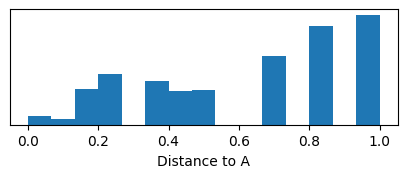

In [34]:
Slate_Histplot(election, s_slates[0], dist='strong', bins=15)

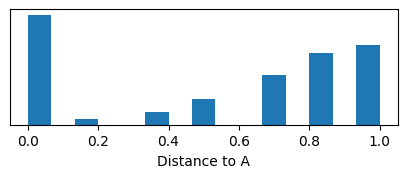

In [35]:
Slate_Histplot(election, s_slates[0], dist='weak', bins=15)

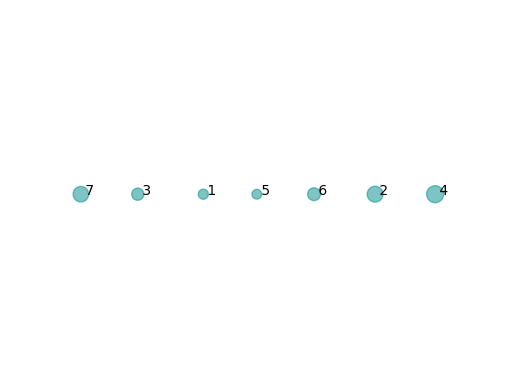

In [36]:
Candidate_MDS_plot(election, party_names = parties, party_colors = 'Auto', dimension=1)

     strong (('Con', 'Con'), ('LD', 'SNP', 'Lab', 'SNP', 'Gr')), score: 0.02620415377817057
     weak (('SNP', 'SNP'), ('Con', 'LD', 'Lab', 'Con', 'Gr')), score: 0.15665046398585947


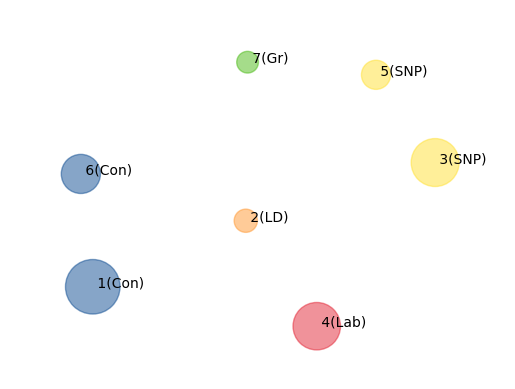

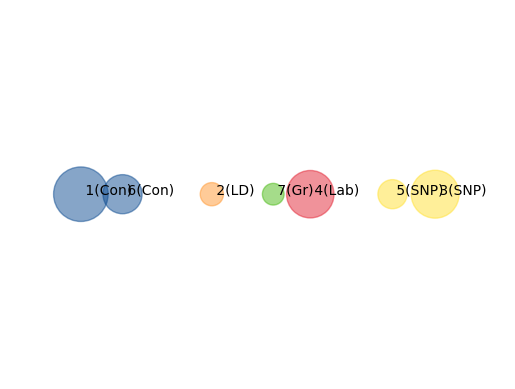

In [88]:
# study Pentland Hills
filename = 'scot-elex/7_cands/edinburgh_2017_ward2.csv'
num_cands, election, cand_names, location = csv_parse(filename)
parties = party_abrevs(cand_names)
# kmeans 
C = kmeans(election)
# strong slate clustering
s_slates, s_dist, s_portion, Cs = Slate_cluster(election, dist='strong', return_data=True)
kmeans_strong = Clustering_closeness(election, C, Cs)
s_slates_p = {i:tuple([parties[cand-1] for cand in s_slate]) for i,s_slate in s_slates.items()}
print(f'     strong {s_slates_p[0],s_slates_p[1]}, score: {kmeans_strong}')
# weak slate clustering
w_slates, w_dist, w_portion, Cw = Slate_cluster(election, dist='weak', return_data=True)
kmeans_weak = Clustering_closeness(election, C, Cw)
w_slates_p = {i:tuple([parties[cand-1] for cand in w_slate]) for i,w_slate in w_slates.items()}
print(f'     weak {w_slates_p[0],w_slates_p[1]}, score: {kmeans_weak}')

# Ballot MDS plots
# projections_6, error = Ballot_MDS_plot(election, party_names=parties, return_data=True, threshold=1, filename='ward6.jpg', dpi = 300) #colored by party of first place vote
#Ballot_MDS_plot(election, Cs, projections=projections) #colored by strong slate clustering assignment
#Ballot_MDS_plot(election, Cw,projections=projections) # colored by weak slate clustering assignment
#Ballot_MDS_plot(election, [C[1],C[0]],projections=projections) # colored by kmeans clustering assignment

# Candidate MDS plots
Candidate_MDS_plot(election, party_names = parties, party_colors = 'Auto')
Candidate_MDS_plot(election, party_names = parties, party_colors = 'Auto', dimension=1)

In [ ]:
s_slates, s_dist, s_portion, s_dist_list, Cs = Slate_cluster(election, dist='strong', return_data=True)
w_slates, w_dist, w_portion, w_dist_list, Cs = Slate_cluster(election, dist='weak', return_data=True)
sns.kdeplot(s_dist_list)
sns.kdeplot(w_dist_list)

(0.1552938577110035, 0.5098415154543681)

In [91]:
len(df)

282

In [27]:
def Slate_Histplot(election, slate, dist = 'strong', filename = None, dpi = 300, bins = 20):
    """
    Plots a histogram of the "distance to A" of the ballots

    Args:
        election : dictionary matching ballots to weights.
        slate: a tuple of the candidates in the first slate.
        dist : one of {'strong','weak'} determines whether to penalize a ballot for having an A-candidate tie with a B-candidate 
        
    Returns:
        (if return_data == False) clustering
        (if return_data == True) slate_dictionary, avg_dist_to_ordered, consistent_portion, clustering
    """
    num_cands = max([item for ranking in election.keys() for item in ranking])
    # create a matrix X whose rows are the Borda proxies of the unique ballots
    # and a dictionary matching each ballot type with its corresponding row in the matrix
    X = []
    ballot_to_row = dict()
    counter = 0
    for ballot, weight in election.items():
        ballot_to_row[ballot]=counter
        X.append(Borda_vector(ballot,num_cands=num_cands))
        counter +=1

    # Form clusters from the best slate
    A = slate
    B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
    a = len(A)
    b = len(B)

    A_dist_list = []
    weight_list = []
    
    for ballot, weight in election.items():
        ballot_proxy = X[ballot_to_row[ballot]]
        A_over_B = 0
        B_over_A = 0
        AB_tie = 0
        for i in A:
            for j in B:
                if ballot_proxy[i-1]>ballot_proxy[j-1]:
                    B_over_A += 1
                elif ballot_proxy[i-1]<ballot_proxy[j-1]:
                    A_over_B += 1
                else:
                    AB_tie += 1

        if dist == 'strong':
            A_dist = (B_over_A+.5*AB_tie)/(a*b)
            B_dist = (A_over_B+.5*AB_tie)/(a*b)
        elif dist == 'weak':
            A_dist = B_over_A/(A_over_B+B_over_A)
            B_dist = A_over_B/(A_over_B+B_over_A) 
        else:
            raise Exception("dist must be one of {'strong','weak'}")

        A_dist_list.append(A_dist)
        weight_list.append(weight)

    fig, ax = plt.subplots(figsize=(5, 1.5))
    plt.hist(A_dist_list, weights=weight_list, bins = bins)
    plt.gca().axes.get_yaxis().set_visible(False) 
    plt.xlabel(f"Distance to A")
    if filename:
        plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    plt.show()


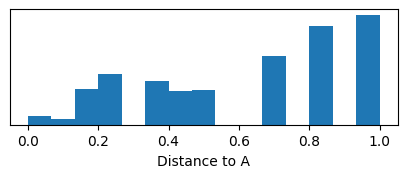

In [209]:
Slate_Histplot(election, s_slates[0], dist='strong', bins=15)

In [28]:
# need to overwrite the following function to change how the labels are displayed

def Candidate_MDS_plot(election, method = 'borda_completion', num_cands = 'Auto', dimension = 2, trunc = None, n_init = 500, metric = True,
                       party_names = None, party_colors = None, filename = None, return_data = False, dpi = 600):
    """
    Prints a multidimensional scaling (MSD) plot of the candidates, labeled by party.  Markers are sized by number of first place votes.
    The "distance" it approximates is one of the following:
    method = 'successive': the portion of ballots on which candidates i & j don't appear next to each other.
    method = 'coappearances': the portion of ballots on which candidates i & j don't both appear.
    method = 'borda' : the average diference in borda_avg points that ballots award to candidates i & j
    method = 'borda_completion' : the average over the completions of the ballots of the diference in the borda points awarded to candidates i & j


    Args
        election : dictionary matching ballots with weights.
        method : choice of {'successive', 'coappearances', 'borda', 'borda_completion'}
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        dimension : choice of {1,2,3} for dimension of MDS plot.
        trunc : truncate all ballots at this position before applying the method.
        n_init : The number of times the SMACOF algorith will run with different initialializations.
        metric : set to True to use metric MDS, or False for non-metric MDS.  Since the 'borda' and 'borda_completions' methods are metrics, metric=True is appropriate for these. 
        party_names : list of strings used as annotation labels.
        party_colors : 'Auto', None, or list of colors.  Only use 'Auto' of party_names is provided.
        filename : set to None if you don't want to save the plot.
        return_data: useful if you want to know the projection error, or for constructing multiple MDS plots of the same election using a common projection.

    Returns:
        projections, error (if return_data is set to True)
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    M = Candidate_dist_matrix(election, num_cands, method = method, trunc = trunc)

    # compute c = marker colors
    if party_colors == None:
        c = ['blue' for _ in range(num_cands)]
    elif party_colors == 'Auto':
        D = {'SNP':'#FFE135', 'Lab': '#E32636', 'Con':'#0F4D92','LD':'#FF9933','Gr':'#4CBB17', 'Ind': '#008B8B'}
        c = []
        for party in party_names:
            c.append(D[party] if party in D.keys() else 'black')
    else:
        c = party_colors

    # compute s = marker sizes
    s = [0 for _ in range(num_cands)]
    for ballot,weight in election.items():
        s[ballot[0]-1]+=weight
    s = .5*np.array(s)

    # compute projections
    model = MDS(n_components=dimension, dissimilarity='precomputed', n_init=n_init, metric=metric)
    projections = model.fit_transform(M)
    error = model.stress_
    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections]) if dimension>1 else np.array([0 for _ in range(num_cands)])

    if dimension<3:
        fig, ax = plt.subplots()
        ax.scatter(X,Y, c = c, s = s, alpha=.5)

        x_margin = (max(X) - min(X)) * 0.2  # 20% margin
        plt.xlim(min(X) - x_margin, max(X) + x_margin)
        if dimension==2:
            y_margin = (max(Y) - min(Y)) * 0.2  # 20% margin
            plt.ylim(min(Y) - y_margin, max(Y) + y_margin)
        ax.grid(False)
        ax.axis('off')

    else:
        Z = np.array([p[2] for p in projections])
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X,Y,Z, c=c, s=s)
        ax.set(xticklabels=[], yticklabels=[], zticklabels=[])

    if not party_names == None:
        for count in range(num_cands):
            if dimension == 3:
                ax.text(X[count],Y[count],Z[count], f" {count+1}")
            else:
                ax.annotate(f" {count+1}", xy=(X[count], Y[count]))

    if filename != None:
        plt.savefig(filename, dpi=dpi)
    plt.show()

    if return_data:
        return projections, error
    